In [38]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from matplotlib import pyplot as plt

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [115]:
def finDif(omega,f,n,bc):
    length = omega[1] - omega[0]
    h = length/(n-1)
    
    a2 = ones((n-2))
    a1 = -16*ones((n-1))
    a0 = 30*ones((n))
    A = diag(a2, -2) + diag(a1, -1) + diag(a0) + diag(a1, +1) + diag(a2, +2)
    A = A/(12*h**2)
    
    x = np.linspace(omega[0], omega[1], n)
    b = f(x)
    
    # Boundary conditions
    A[0,:] = 0
    A[:,0] = 0
    A[-1,:] = 0
    A[:,-1] = 0
    # Diagonal elements should be one
    A[0,0] = 1
    A[-1,-1] = 1
    
    b[0] = bc[0]
    b[-1] = bc[1]
    
    return A, b

Call the function using:

In [116]:
omega = [0,pi]
f = lambda x : sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [117]:
def LU(A):
    # The LU factorization of the system matrix A
    
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = triu(A)
    return L, U

L, U = LU(A)

In [118]:
def cholesky(A):
    # The Cholesky factorization of the system matrix A
    
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = sqrt(A[-1,-1])
    L=tril(A)
    
    return L, L.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [77]:
def L_solve(L,rhs):
    x = zeros_like(rhs)
    N = len(L)
        
    x[0] = rhs[0]/L[0,0]
    for i in range(1,N):
        x[i] = (rhs[i] - dot(L[i, 0:i], x[0:i]))/L[i,i]
    
    return x

In [78]:
def U_solve(U,rhs):
    x = zeros_like(rhs)
    N=len(U)
            
    x[-1] = rhs[-1]/U[-1,-1]
    for i in reversed(range(N-1)):
        x[i] = (rhs[i] -dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
        
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

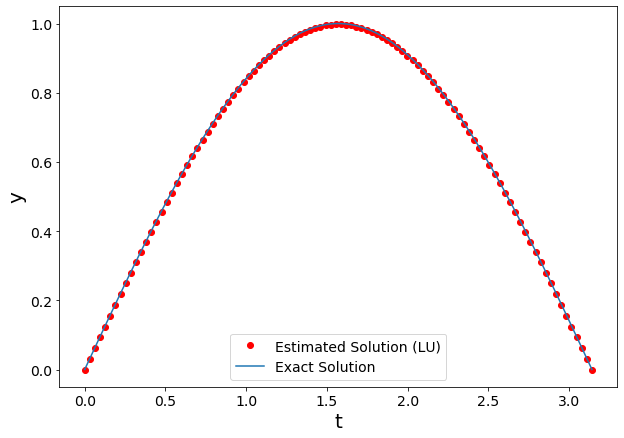

In [123]:
x = np.linspace(omega[0], omega[1], n)

w = L_solve(L,b)
u = U_solve(U,w)

# A1 = A.copy()
# u = linalg.solve(A1, f(x))
u_ex = np.sin(x)


figure(figsize=(10,7))
_ = plot(x,u,'ro', label='Estimated Solution (LU)')
_ = plot(x,u_ex, label='Exact Solution')
xlabel('t', fontsize=20)
ylabel('y', fontsize=20)
xticks(fontsize=14)
yticks(fontsize=14)
legend(fontsize=14);


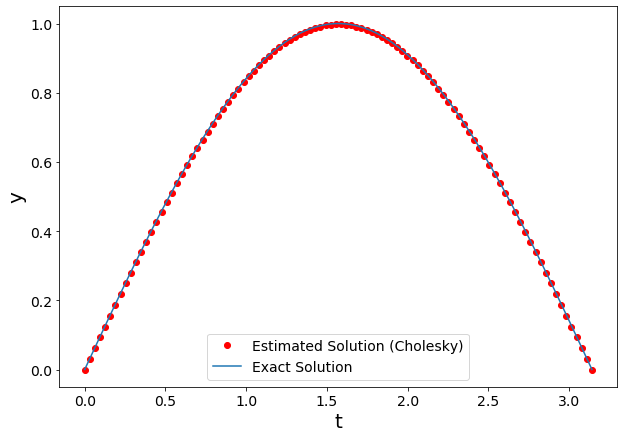

In [122]:
x = np.linspace(omega[0], omega[1], n)

y = L_solve(HT,f(x))
u = U_solve(H,y)

# A1 = A.copy()
# u = linalg.solve(A1, f(x))
u_ex = np.sin(x)


figure(figsize=(10,7))
_ = plot(x,u,'ro', label='Estimated Solution (Cholesky)')
_ = plot(x,u_ex, label='Exact Solution')
xlabel('t', fontsize=20)
ylabel('y', fontsize=20)
xticks(fontsize=14)
yticks(fontsize=14)
legend(fontsize=14);


Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [ ]:
f = x*(1.-x)

omega = [0,1]
f = lambda x : x*(1-x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)
x = np.linspace(omega[0], omega[1], n)



# Solve the linear system using numpy
A1 = A.copy()
u = linalg.solve(A1, f(x))
u_ex = (x**4)/12. - (x**3)/6. + x/12.

# Plot the FD and exact solution
_ = plot(x,u,'ro')
_ = plot(x,u_ex)

In [99]:
def errors(f, bc, omega, n_grid_range):
    err = empty_like(n_grid_range, dtype=float64)
    
    for i, n in enumerate(n_grid_range):
        x = np.linspace(omega[0], omega[1], n)
        A, b = finDif(omega, f, n, bc)
        
        L, U = LU(A)
        w = L_solve(L,b)
        u = U_solve(U,w)
        
        u_ex = (x**4)/12. - (x**3)/6. + x/12.
        err[i] = linalg.norm(u - u_ex)

    return err

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
 <a list of 5 Text yticklabel objects>)

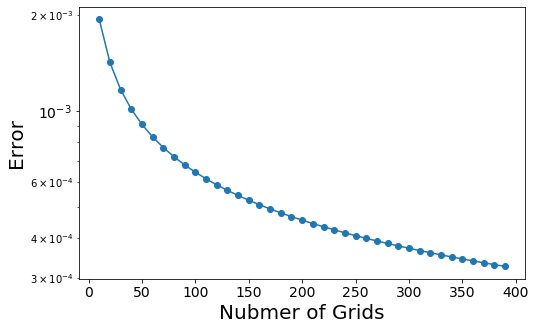

In [112]:
omega = [0,1]
f = lambda x : x*(1-x)
n=100
bc = [0,0]

n_grid_range = arange(10,400,10)

err = errors(f, bc, omega, n_grid_range)

figure(figsize=(8,5))
plot(n_grid_range, err, 'o-')
yscale('log')
xlabel('Nubmer of Grids', fontsize=20)
ylabel('Error', fontsize=20)
xticks(fontsize=14)
yticks(fontsize=14)

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [ ]:
def condNumb(A):
    pass #TODO
    return condNu

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [ ]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
    pass #TODO

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [ ]:
#TODO

Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [ ]:
#TODO

Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
#TODO


**- Solving differential equation using backward Euler's method and Newton's method**

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [67]:
def f(y, y_prev, h, t):
    return y+h*t*y**2-y_prev

def fp(y, h, t):
    return 2*h*t*y+1

def newtonMethod(g, gp, y0, e=1e-10, nIt_max=1000):
    
    n = 0
    y = y0
    err = 10

    while(n < nIt_max and err > e):
        yNew = y - g(y)/gp(y)
        
        err = abs(g(yNew))
        
        y = yNew
        n += 1
        
    return y
        
def backwardEuler(y0, t0, t_end, n):
    h = (t_end-t0)/n
    t = arange(t0, t_end+h/2, h)
    y = zeros_like(t)
    y[0] = y0
    
    for i in range(1, t.size):
        
        g = lambda x: f(x, y[i-1], h, t[i])
        gp = lambda x: fp(x, h, t[i])
        y[i] = newtonMethod(g, gp, y0)
        
    return t, y

def exactSolution(t):
    return 2/(t**2+2)

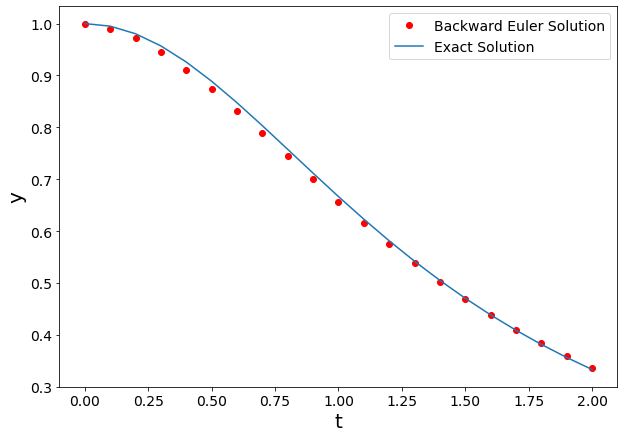

In [66]:
y0 = 1
t0 = 0
t_end = 2
n = 20


t, y = backwardEuler(y0, t0, t_end, n)

figure(figsize=(10,7))
plot(t, y, 'or', label='Backward Euler Solution')
plot(t, exactSolution(t), label='Exact Solution')
xlabel('t', fontsize=20)
ylabel('y', fontsize=20)
xticks(fontsize=14)
yticks(fontsize=14)
legend(fontsize=14);
